In [ ]:
import numpy as np
import odc.stac
import pandas as pd
import planetary_computer
import pyproj
import pystac_client
import xarray as xr
from dask.distributed import Client
from IPython.display import Image
from pystac.extensions.eo import EOExtension as eo
from dask_ml.cluster import KMeans
import matplotlib.pyplot as plt
import contextily as cx
from skimage.filters import threshold_otsu
import dask.array as da
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle

## Data Preparation

As in previous weeks, we'll start by importing our data from Microsoft's Planetary Computer. We're searching for the Landsat 8, Level 2 collection, filtered for the summer of 2017 over a lake in Nevada, USA.

In [123]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "2017-06-01/2017-09-30"  # Summer months of 2017
collection = "landsat-c2-l2"
platform = "landsat-8"
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)
items = search.item_collection()
print(f"Returned {len(items)} Items:")
[[i, item.id] for i, item in enumerate(items)]

Returned 3 Items:


[[0, 'LC08_L2SP_042033_20170718_02_T1'],
 [1, 'LC08_L2SP_042033_20170702_02_T1'],
 [2, 'LC08_L2SP_042033_20170616_02_T1']]

In [124]:
item = items[1]  # select one of the results

Notice how cloud cover here is minimal! This makes our lives easy.

In [125]:
Image(url=item.assets["rendered_preview"].href)

In the data processing steps that follow, we're mostly just copy and pasting directly from the tutorial. We'll get more analytical when it comes time to actually run our clustering model.

In [126]:
assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]
bands

,common_name,description,name,center_wavelength,full_width_half_max
0,red,Visible red,OLI_B4,0.65,0.04
1,blue,Visible blue,OLI_B2,0.48,0.06
2,green,Visible green,OLI_B3,0.56,0.06
3,nir08,Near infrared,OLI_B5,0.87,0.03
4,lwir11,Long-wave infrared,TIRS_B10,10.90,0.59
5,swir16,Short-wave infrared,OLI_B6,1.61,0.09
6,swir22,Short-wave infrared,OLI_B7,2.20,0.19
7,coastal,Coastal/Aerosol,OLI_B1,0.44,0.02


In [127]:
ds_2017 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
).isel(time=0)

Here, we can view our data array in `xarray` format. This is a good opportunity to mentally connect the concept of a data array to an EO data cube. We can clearly see our four dimensions of x, y, bands, and time.

In [128]:
epsg = item.properties["proj:code"]
ds_2017.attrs["crs"] = f"epsg:{epsg}"

da_2017 = ds_2017.to_array(dim="band")
da_2017

<xarray.DataArray (band: 8, y: 1128, x: 950)> Size: 17MB
dask.array<stack, shape=(8, 1128, 950), dtype=uint16, chunksize=(1, 1128, 950), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
Attributes:
    crs:      epsg:EPSG:32611

Now comes the part that needs some explanation. We're going to flatten our array to create vectors of the pixels of each image. This is a really important concept in remote sensing and deep learning--we'll about it a lot in the second half of the semester. Here's an expllanation from the Landsat ML Cookbook tutorial:

> The shape of our data is currently `n_bands`, `n_y`, `n_x`. In order for `dask-ml` / `scikit-learn` to consume our data, we’ll need to reshape our image stacks into `n_samples`, `n_features`, where `n_features` is the number of wavelength-bands and `n_samples` is the total number of pixels in each wavelength-band image. Essentially, we’ll be creating a vector of pixels out of each image, where each pixel has multiple features (bands), but the ordering of the pixels is no longer relevant to the computation.
> 
> By using xarray methods to flatten the data, we can keep track of the coordinate labels ‘x’ and ‘y’ along the way. This means that we have the ability to reshape back to our original array at any time with no information loss!

Here's a nice explanation from [a Medium article by Hause Lin](https://medium.com/data-science/reshaping-numpy-arrays-in-python-a-step-by-step-pictorial-tutorial-aed5f471cf0b):

![Python numpy reshape and stack cheatsheet](https://miro.medium.com/1%2AlFZzE9PgKTRR8jlFI4EUtw.png)

Now we have eight vectors of pixels--one for each band!

In [129]:
flattened_xda = da_2017.stack(z=("x", "y"))  # flatten each band
flattened_t_xda = flattened_xda.transpose("z", "band")
flattened_t_xda

<xarray.DataArray (z: 1071600, band: 8)> Size: 17MB
dask.array<transpose, shape=(1071600, 8), dtype=uint16, chunksize=(1071600, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 9MB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

Next, we need to standardize our data. We're applying this because k-means is calculated based on Euclidian distance, and therefore sensitive to scale. If one feature has a much larger range of values than another, it can dominate the distance calculation and skew the results. Standardizing the data ensures that each feature contributes equally to the distance calculations, leading to more meaningful clustering results. (As we'll see later, this is not so relevant when we're working with tree-based models like Random Forests or with deep learning.)

In [130]:
with xr.set_options(keep_attrs=True):
    rescaled_xda = (flattened_t_xda - flattened_t_xda.mean()) / flattened_t_xda.std()
rescaled_xda

<xarray.DataArray (z: 1071600, band: 8)> Size: 69MB
dask.array<truediv, shape=(1071600, 8), dtype=float64, chunksize=(1071600, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 9MB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

## K-Means Clustering

In [131]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.2.0.2:43963/status,
Dashboard: http://10.2.0.2:43963/status,Workers: 1
Total threads: 16,Total memory: 54.73 GiB
Status: running,Using processes: False
Comm: inproc://10.2.0.2/124505/19,Workers: 0
Dashboard: http://10.2.0.2:43963/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.2.0.2/124505/22,Total threads: 16
Dashboard: http://10.2.0.2:44713/status,Memory: 54.73 GiB
Nanny: None,


In [132]:
X = client.persist(rescaled_xda)
X.shape

(1071600, 8)

Now it's time for our clustering! The original tutorial uses spectral clustering, which is a slightly more sophisticated approach to k-means. We're using regular old k-means here just because the spectral clustering module was behaving weirdly in Dask. The concepts are the same, though.

The idea is simply to group pixels bsaed on similarity across all wavelength bands, based on Euclidian distance in multi-dimensional space. Here, we're using four clusters, per the tutorial, although this could be adjusted. This is _unsupervised_ clustering, meaning we don't provide any labels or guidance to the model about what the clusters should represent. The model simply identifies patterns in the data and groups similar pixels together. 

Lastly, I want to be clear that we're using k-means here because it's reasonably easy to understand and implement. In practice, more advanced clustering algorithms (like spectral clustering, hierarchical clustering, or DBSCAN) may yield better results depending on the specific characteristics of the dataset and the goals of the analysis. But k-means is what's available in Dask, so... it's what we're using.

In [ ]:


kmeans = KMeans(n_clusters=4, random_state=0, max_iter=100)
kmeans.fit(X)
labels = kmeans.labels_.compute()

template = flattened_t_xda[:, 0]
output_array = template.copy(data=labels)
output_array

<xarray.DataArray (z: 1071600)> Size: 4MB
array([1, 1, 1, ..., 0, 0, 0], shape=(1071600,), dtype=int32)
Coordinates:
  * z            (z) object 9MB MultiIndex
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

Per the tutorial:
> Once the computation is done, we can use the coordinates of our input array to restack our output array back into an image. Again, one of the main benefits of using `xarray` for this stacking and unstacking is that it keeps track of the coordinate information for us.

In [134]:
unstacked_2017 = output_array.unstack()
unstacked_2017

<xarray.DataArray (x: 950, y: 1128)> Size: 4MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(950, 1128), dtype=int32)
Coordinates:
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
Attributes:
    crs:      epsg:EPSG:32611

And now the moment of truth, mapping the clusters:

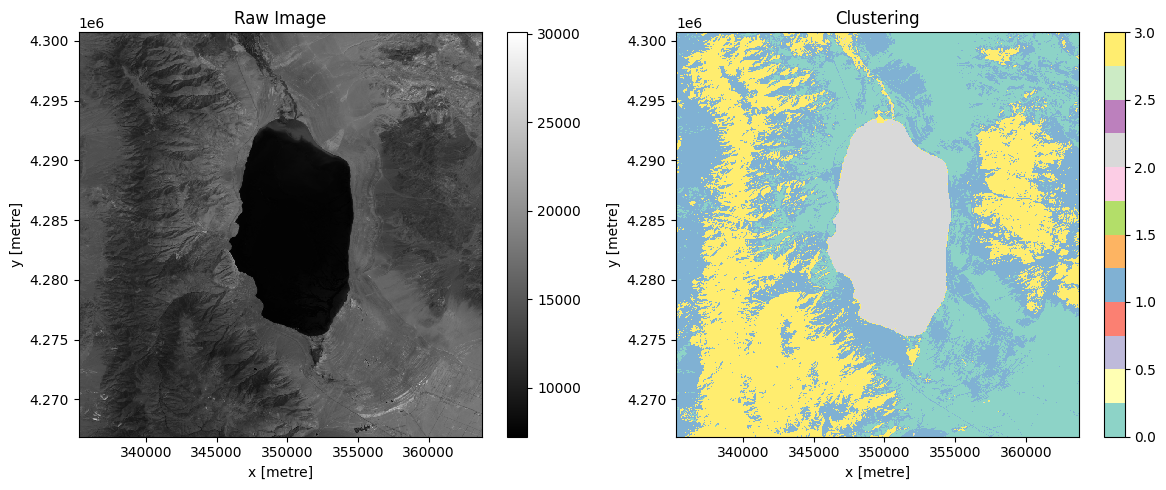

In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot raw
da_2017.sel(band="red").plot(ax=ax1, cmap="gray")
ax1.set_title("Raw Image")

# Plot clustering - transpose if needed
unstacked_2017.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)  # Add .T to transpose
ax2.set_title("Clustering")

plt.tight_layout()
plt.show()

As you can see, the clustering results correspond quite well to the water/non-water. It's hard to tell from one band alone whether they correspond concretely to different land cover classes, but it's clear that the model is picking up on some meaningful patterns in the data.

### 1988

Per the tutorial, we'll expand our analysis to clustering data from 1988. Note that we're _not_ applying a model trained on 2017 data to the 1988 data. Instead, we're running the k-means on the 1988 data itself.

In [136]:
bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "1988-06-01/1988-09-30"  # Summer months of 1988
collection = "landsat-c2-l2"
platform = "landsat-5"  # Searching through an earlier landsat mission
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)

items = search.get_all_items()
item = items[1]  # select one of the results

assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]

ds_1988 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
).isel(time=0)

epsg = item.properties["proj:code"]
ds_1988.attrs["crs"] = f"epsg:{epsg}"

da_1988 = ds_1988.to_array(dim="band")

flattened_xda = da_1988.stack(z=("x", "y"))
flattened_t_xda = flattened_xda.transpose("z", "band")
with xr.set_options(keep_attrs=True):
    rescaled_xda = (flattened_t_xda - flattened_t_xda.mean()) / flattened_t_xda.std()
rescaled_xda

X = client.persist(rescaled_xda)

kmeans = KMeans(n_clusters=4, random_state=0, max_iter=100)
kmeans.fit(X)
labels = kmeans.labels_.compute()

template = flattened_t_xda[:, 0]
output_array = template.copy(data=labels)
unstacked_1988 = output_array.unstack()

Now, plotting them side by side...

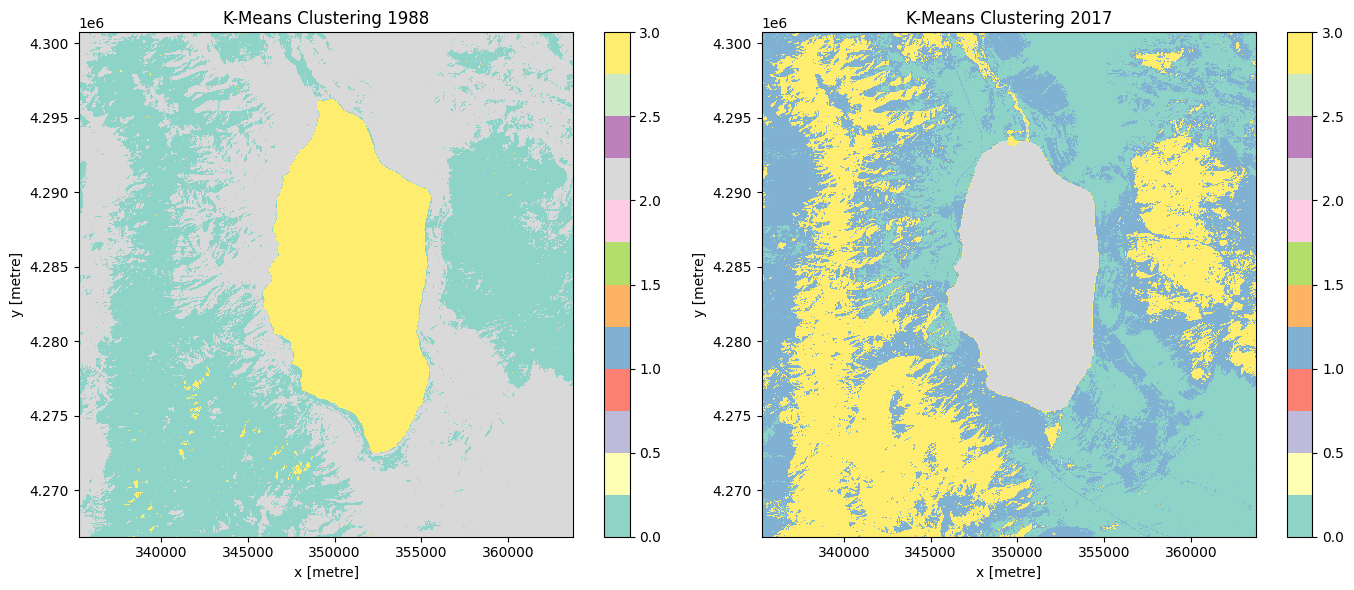

In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

unstacked_1988.T.plot(ax=ax1, cmap="Set3", vmin=0, vmax=3)
ax1.set_title("K-Means Clustering 1988")

unstacked_2017.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)
ax2.set_title("K-Means Clustering 2017")

plt.tight_layout()
plt.show()

Now with some quick data wrangling, we can create water masks for both years and compare them directly.

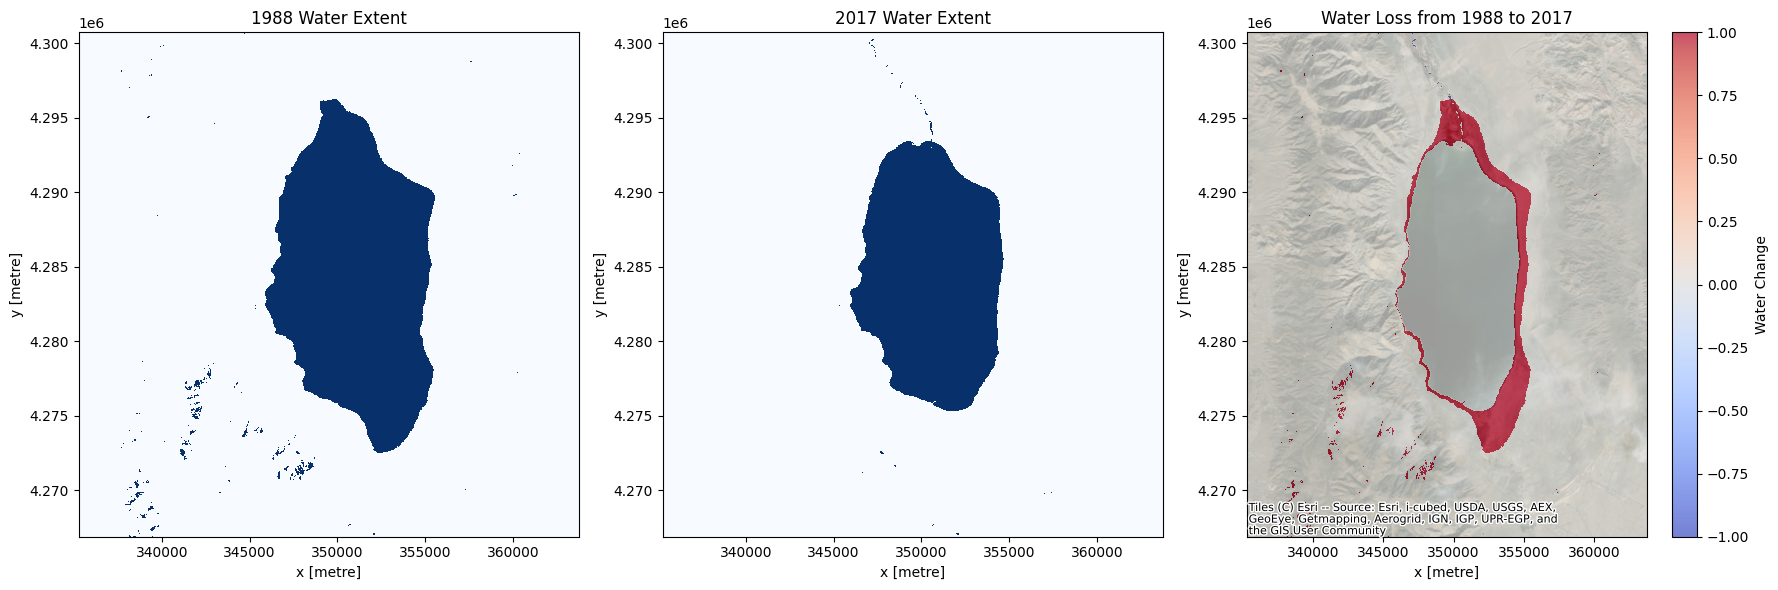

In [ ]:

lon_lake_center = -118.71
lat_lake_center = 38.7

# Fix the CRS string - remove double prefix
crs_string = str(unstacked_1988.crs).replace("epsg:EPSG:", "EPSG:")
proj = pyproj.Proj(crs_string)
lake_center_x, lake_center_y = proj(lon_lake_center, lat_lake_center)

water_cluster_1988 = int(
    unstacked_1988.sel(x=lake_center_x, y=lake_center_y, method="nearest")
)
water_cluster_2017 = int(
    unstacked_2017.sel(x=lake_center_x, y=lake_center_y, method="nearest")
)

# Create water masks
with xr.set_options(keep_attrs=True):
    water_1988 = (unstacked_1988 == water_cluster_1988).astype(int)
    water_2017 = (unstacked_2017 == water_cluster_2017).astype(int)

# Plot all three in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

water_1988.T.plot(ax=ax1, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax1.set_title("1988 Water Extent")

water_2017.T.plot(ax=ax2, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax2.set_title("2017 Water Extent")

with xr.set_options(keep_attrs=True):
    water_diff = water_1988 - water_2017

water_diff.T.plot(
    ax=ax3,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    alpha=0.7,
    cbar_kwargs={"label": "Water Change"},
)
cx.add_basemap(ax3, crs=crs_string, source=cx.providers.Esri.WorldImagery)
ax3.set_title("Water Loss from 1988 to 2017")

plt.tight_layout()
plt.show()

## K-Means Compared

Impressive! With just unsupervised clustering, we've managed to classify water and non-water areas quite well in both years. However, based on the lecture about indexing from last week, you might be asking yourself, "Wait, couldn't you accomplish the same thing without machine learning by applying a spectral index?" If so, excellent! You're thinking like a remote sensing scientist. 

We explored k-means here for pedagogical reasons, but--also for pedagogical reasons--it's important to critically evaluate whether this is the best approach for the task at hand. We'll compare our k-means results to [MNDWI](https://www.opendatacube.org/mndwi), an index which combines the green and SWIR1 bands to enhance water features. We'll also apply Otsu's method to automatically determine an optimal threshold for water classification.

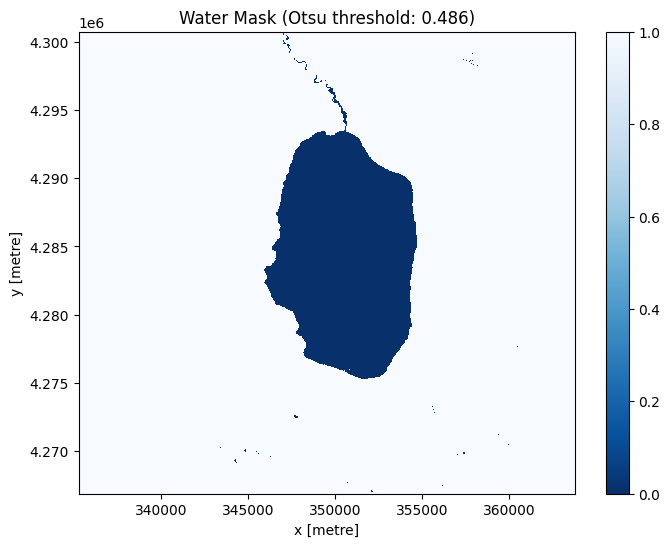

In [ ]:


# Calculate MNDWI
mndwi = (ds_2017.green - ds_2017.swir16) / (ds_2017.green + ds_2017.swir16)

# Compute Otsu threshold
threshold = threshold_otsu(mndwi.values.flatten())

# Create binary mask
water_mask = mndwi > threshold

# Plot
water_mask.plot(cmap="Blues_r", figsize=(8, 6))
plt.title(f"Water Mask (Otsu threshold: {threshold:.3f})")
plt.show()

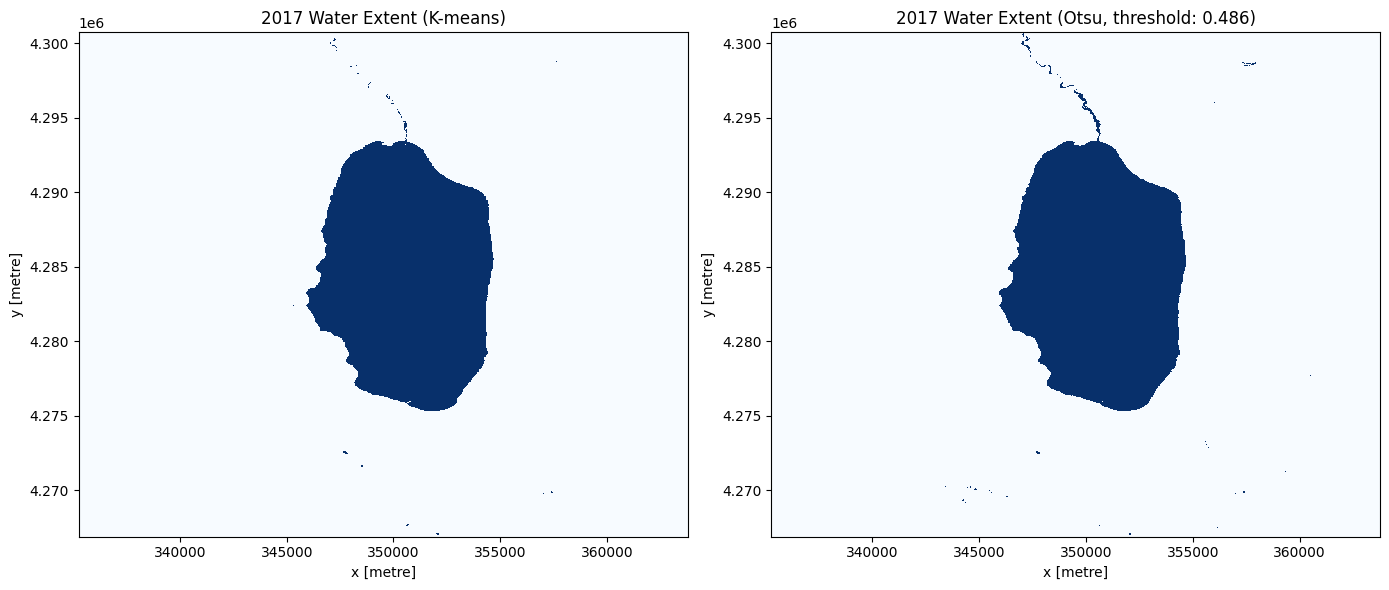

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# K-means water mask
water_2017.T.plot(ax=ax1, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax1.set_title("2017 Water Extent (K-means)")

# Otsu water mask
water_mask.plot(ax=ax2, cmap="Blues_r", add_colorbar=False)
ax2.set_title(f"2017 Water Extent (Otsu, threshold: {threshold:.3f})")

plt.tight_layout()
plt.show()

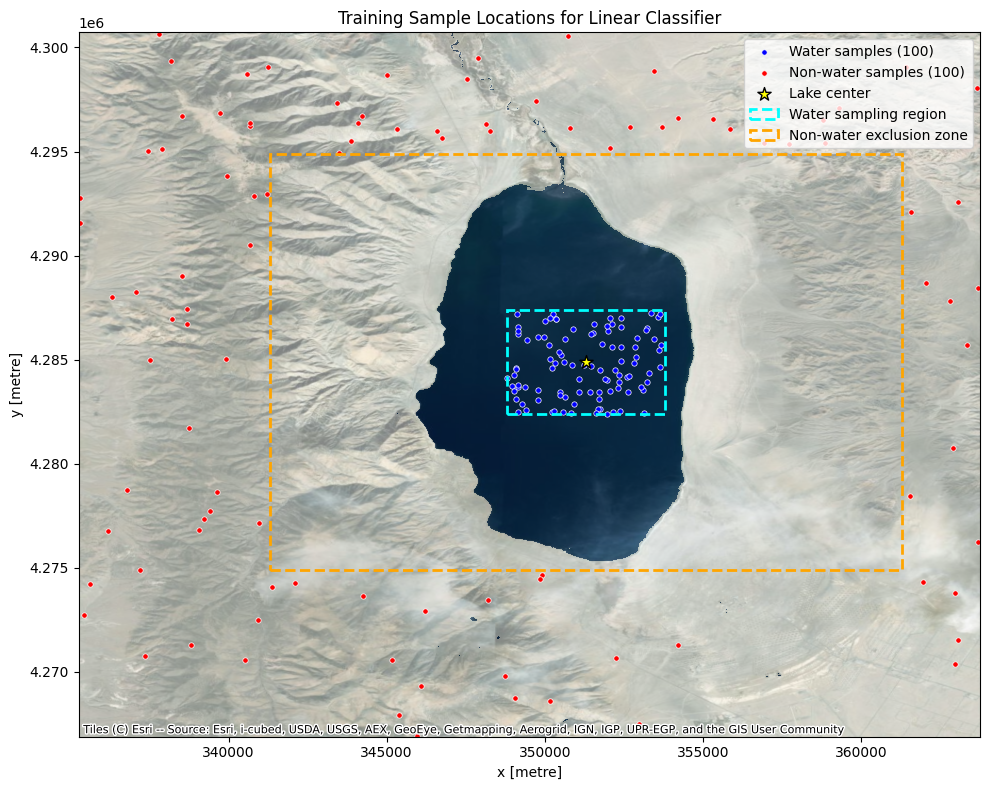

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Define the sampling regions
buffer_m = 2500  # inner buffer for water samples
outer_buffer_m = 10000  # non-water starts beyond this distance

# Water samples: within inner buffer
lake_mask = (abs(flattened_t_xda.x - lake_center_x) < buffer_m) & (
    abs(flattened_t_xda.y - lake_center_y) < buffer_m
)

# Non-water samples: OUTSIDE the outer buffer
nonwater_mask = (abs(flattened_t_xda.x - lake_center_x) >= outer_buffer_m) | (
    abs(flattened_t_xda.y - lake_center_y) >= outer_buffer_m
)

# Sample points
water_indices = np.where(lake_mask.values)[0]
water_sample_idx = np.random.choice(water_indices, size=100, replace=False)

nonwater_indices = np.where(nonwater_mask.values)[0]
nonwater_sample_idx = np.random.choice(nonwater_indices, size=100, replace=False)

# Plot basemap with imagery
water_2017.T.plot(ax=ax, cmap="Blues", vmin=0, vmax=1, alpha=0.5, add_colorbar=False)
cx.add_basemap(ax, crs=crs_string, source=cx.providers.Esri.WorldImagery)

# Extract coordinates
water_coords = flattened_t_xda.isel(z=water_sample_idx)
water_x, water_y = water_coords.x.values, water_coords.y.values

nonwater_coords = flattened_t_xda.isel(z=nonwater_sample_idx)
nonwater_x, nonwater_y = nonwater_coords.x.values, nonwater_coords.y.values

# Plot training points
ax.scatter(
    water_x,
    water_y,
    c="blue",
    s=15,
    label="Water samples (100)",
    edgecolor="white",
    linewidth=0.5,
)
ax.scatter(
    nonwater_x,
    nonwater_y,
    c="red",
    s=15,
    label="Non-water samples (100)",
    edgecolor="white",
    linewidth=0.5,
)

# Mark lake center
ax.scatter(
    lake_center_x,
    lake_center_y,
    c="yellow",
    s=100,
    marker="*",
    label="Lake center",
    edgecolor="black",
)



rect_inner = Rectangle(
    (lake_center_x - buffer_m, lake_center_y - buffer_m),
    2 * buffer_m,
    2 * buffer_m,
    linewidth=2,
    edgecolor="cyan",
    facecolor="none",
    linestyle="--",
    label="Water sampling region",
)
rect_outer = Rectangle(
    (lake_center_x - outer_buffer_m, lake_center_y - outer_buffer_m),
    2 * outer_buffer_m,
    2 * outer_buffer_m,
    linewidth=2,
    edgecolor="orange",
    facecolor="none",
    linestyle="--",
    label="Non-water exclusion zone",
)
ax.add_patch(rect_inner)
ax.add_patch(rect_outer)

ax.legend(loc="upper right")
ax.set_title("Training Sample Locations for Linear Classifier")
plt.tight_layout()
plt.show()

In [144]:
# Combine and train
X_train = np.vstack([X_water, X_nonwater])
y_train = np.concatenate([y_water, y_nonwater])

clf = LogisticRegression()
clf.fit(da.from_array(X_train), da.from_array(y_train))

# Rechunk so bands are in one chunk, then predict
X_rechunked = X.data.rechunk({1: X.data.shape[1]})
water_labels = clf.predict(X_rechunked).compute()

# Reshape to spatial grid
water_classified = template.copy(data=water_labels).unstack()

In [ ]:


X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

clf = LogisticRegression()
clf.fit(da.from_array(X_tr), da.from_array(y_tr))

y_pred = clf.predict(da.from_array(X_te)).compute()

print("Classification Report (30% held-out test set):")
print(classification_report(y_te, y_pred, target_names=["Non-water", "Water"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred))

Classification Report (30% held-out test set):
              precision    recall  f1-score   support

   Non-water       1.00      0.93      0.96        29
       Water       0.94      1.00      0.97        31

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Confusion Matrix:
[[27  2]
 [ 0 31]]


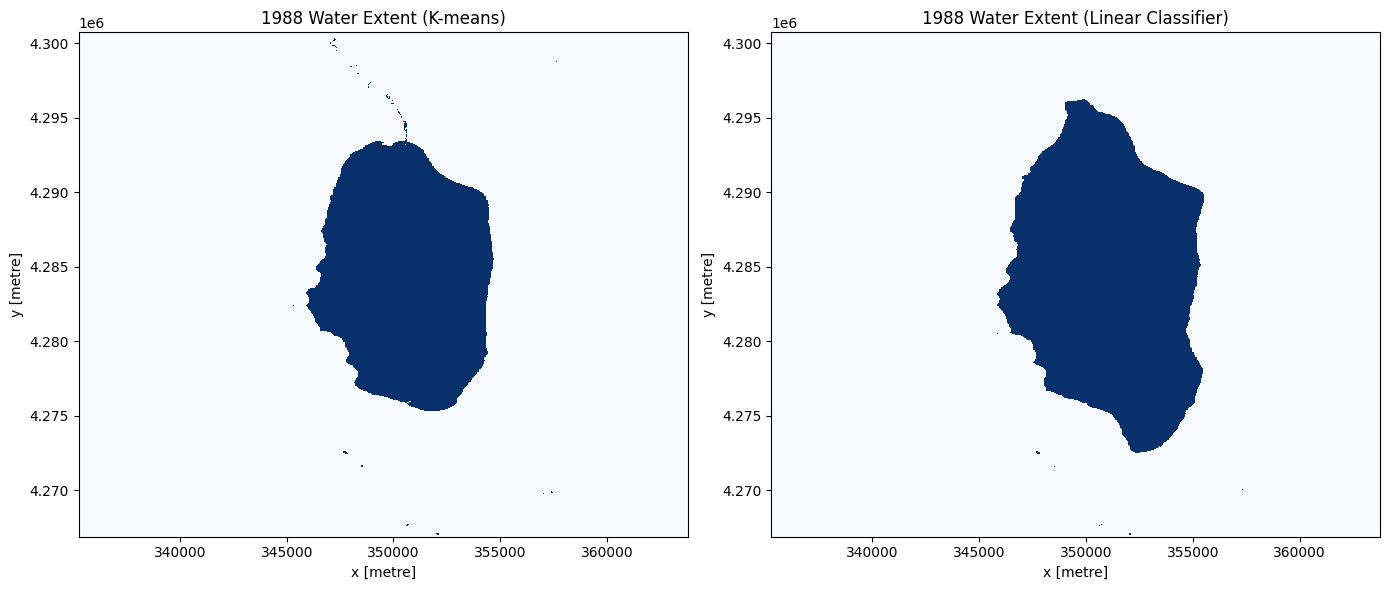

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# K-means water mask
water_2017.T.plot(ax=ax1, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax1.set_title("1988 Water Extent (K-means)")

# Linear classifier water mask
water_classified.T.plot(ax=ax2, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax2.set_title("1988 Water Extent (Linear Classifier)")

plt.tight_layout()
plt.show()